# Texas Department of Transportation - Bridge Condition Prediction and Analysis

## Summary

The aim of this report is to ascertain if the current condition of Texas bridges can be predicted using the following variables (using the information available in 'tx19_bridges_sample.csv' data file) :

1. Age (derived from variable Year)
1. average use (variable AverageDaily)
1. percent trucks (variable Trucks_percent)
1. material (variable Material)
1. design (variable Design)

Specifically, the report will analyse the available data and aim to anwer the following questions:
1. How well the proposed variables can predict the bridge condition?
1. Which of the proposed variables has more influence on the current condition?

The report is divided into 4 sections:

 1. Section 1 - Data Preparation<br>
     1. Importing the original dataset
     1. Deriving the Age variable
     1. Section 1C: Data cleaning - removing outliers, null values, and category reduction
     1. Deriving current condition
     1. New refined dataset for further analysis
 
 2. Section 2 - Exploratory analysis <br>
     1. Relationship between continous variables
     1. Relationship between categorical variables
     1. Relationship between continuous and categorical variables
     1. Preliminary conclusions
     
 3. Section 3 - Regression analysis<br>
     1. Reference encoding categorical variables
     1. Linear regression and analysis
     1. Removing outliers and re-running the model
     
 4. Section 4 - Conclusions 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Section 1: Data Preparation

### Section 1A: Importing the original dataset

The data will be imported from the 'tx19_bridges_sample.csv' file. The categories in the dataset are assigned the relevant categorical datatype in the below code and the imported dataset is displayed underneath. The dataset consists of 34293 bridges and 24 columns of various data types.

In [2]:
# The code below declares a catageorical type with categories in a specified order
# This can be used for an ordinal variable
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

#Categories for the scour column
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

#import data and store in variable bridges
bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges  

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


### Section 1B: Deriving the age variable

Since the dataset doesn't have an age column, it will be derived from the 'Year' variable by simply using the formula *Age = (2021 - 'Year')* for each bridge.

In [3]:
#get age variable
bridges = bridges.assign(Age = 2021 - bridges.Year)
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,16
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,16
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,9
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120,71
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600,27
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600,21
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,25


### Section 1C: Data cleaning - removing outliers, null values, and category reduction

Since there are only a limited number of columns of interest, the data will first be reduced to only include these variables:

- Age
- Material
- Design
- Superstr_rating (to derive current condition)
- Substr_rating (to derive current condition)
- Deck_rating (to derive current condition)
- AverageDaily
- Trucks_percent

The below shows the first five rows of the reduced data:

In [4]:
bridges_reduced = bridges.loc[:,['Age', 'Material', 'Design', 'Superstr_rating', 'Substr_rating', 'Deck_rating', 'AverageDaily', 'Trucks_percent']].copy()
bridges_reduced.head()

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent
Structure_id,,,,,,,,
000021521-00101,16,Concrete,Slab,Very Good,Very Good,Good,1,0.0
000021521-00181,16,Concrete,Slab,Good,Very Good,Good,1,0.0
000021521-TMP20,9,Concrete,Beam,Very Good,Very Good,Very Good,100,0.0
000021525-00012,71,Timber,Beam,Good,Poor,Good,80,0.0
000021580-00092,17,Concrete,Beam,Very Good,Very Good,Good,150,4.0


Investigating the summary of this reduced data to detect obvious problematic entries (such as null values, incorrect datatypes etc.):

In [5]:
bridges_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34293 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Age              34293 non-null  int64   
 1   Material         34293 non-null  category
 2   Design           34293 non-null  category
 3   Superstr_rating  34291 non-null  category
 4   Substr_rating    34293 non-null  category
 5   Deck_rating      34288 non-null  category
 6   AverageDaily     34293 non-null  int64   
 7   Trucks_percent   34293 non-null  float64 
dtypes: category(5), float64(1), int64(2)
memory usage: 1.2+ MB


The above shows that there are a few variables (Superstr_rating and Deck_rating) that have missing data or data type of null within them. Displaying these and investigating them further: 

In [6]:
bridges_reduced[bridges_reduced.isnull().any(axis = 1)]

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent
Structure_id,,,,,,,,
010920004518118,51,Concrete,Beam,Good,Good,NaN,7520,2.0
021200AA0205001,75,Steel,Beam,NaN,Fair,Good,340,0.0
031690AA0273001,13,Concrete,Other,Very Good,Very Good,NaN,20,0.0
121020B37610001,13,Concrete,Other,Good,Good,NaN,100,0.0
131580AA0323001,22,Steel,Arch,Very Good,Good,NaN,60,0.0
190190102001006,30,Concrete,Other,Good,Good,NaN,160,16.0
211090AA0348002,61,Concrete,Other,NaN,Poor,Failing,50,0.0


It is unclear what the best approach is to handle these null values. The following options were considered:

 - Ignore them - simplest option that should not affect the end results due to the small number of values that are being ignored
 - Excluding these bridges from the analysis completely - another simple option that should not affect the end results terribly as the data will only exclude 7 bridges out of 34293. However, since the rest of the variables for these bridges seem to consist of believable and sensible data, it will result in loss of good data.
 - Another approach can be to assign the NaNs with the most frequently occuring value (mode) for the variable. 
 - Create a contingency table using the rest of the bridges, and determine the expected value of the missing value using conditional probabilities.
 
The third approach has been chosen here as using the mode is simple, allows the rest of the data to be used later, and due to the small number of replacements, doesn't affect the overall analysis. Again, the analysis can be reworked, if the customer so wishes with their preferred choice. 

In [7]:
#replace nan values with the mode of the column
bridges_reduced.Superstr_rating.fillna(bridges_reduced.Superstr_rating.mode().iloc[0], inplace = True)
bridges_reduced.Deck_rating.fillna(bridges_reduced.Deck_rating.mode().iloc[0], inplace = True)

In [8]:
bridges_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34293 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Age              34293 non-null  int64   
 1   Material         34293 non-null  category
 2   Design           34293 non-null  category
 3   Superstr_rating  34293 non-null  category
 4   Substr_rating    34293 non-null  category
 5   Deck_rating      34293 non-null  category
 6   AverageDaily     34293 non-null  int64   
 7   Trucks_percent   34293 non-null  float64 
dtypes: category(5), float64(1), int64(2)
memory usage: 1.2+ MB


As shown above, the null values have been successfully replaced. Next, the continuous variables will be investigated for any outliers. Plotting the histograms:

array([[<AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'AverageDaily'}>],
       [<AxesSubplot:title={'center':'Trucks_percent'}>]], dtype=object)

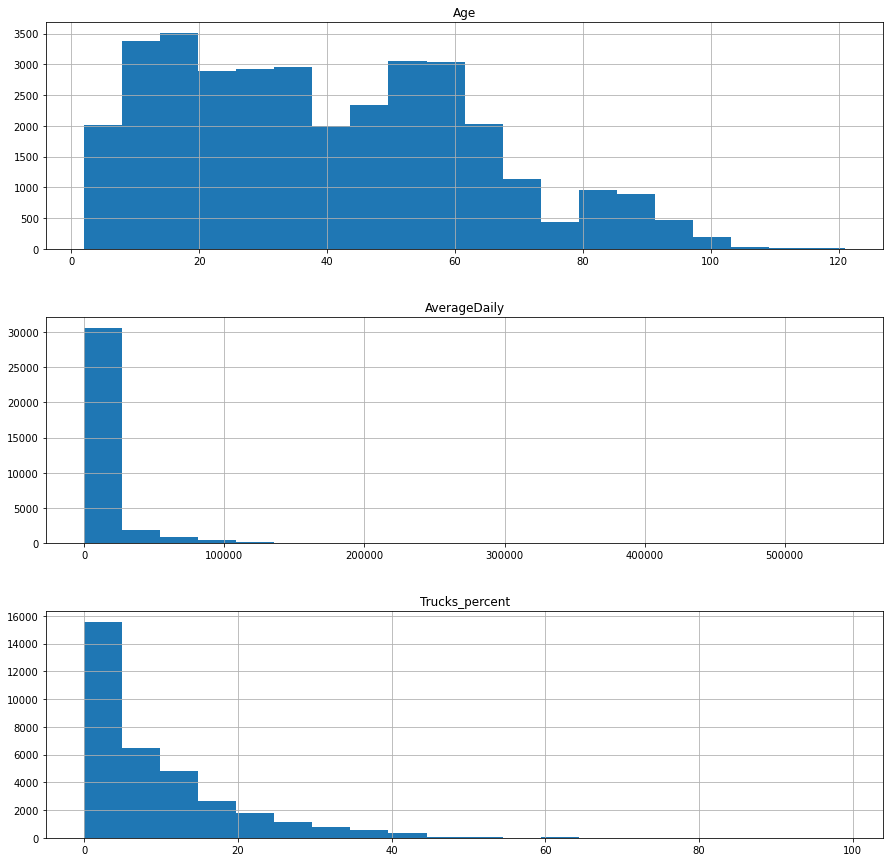

In [9]:
bridges_reduced.hist(layout = (3,1), figsize = (15,15), bins = 20)

From the above histograms, it can be seen that AverageDaily and Trucks_percent have a heavy positive skew, whereas the Age variable has a positive skew that's not as pronounced. Each of the variables should be looked at more closely to determine if there are any anomalies that can be excluded. It has been explicitly asked to remove really old bridges from the data (possibly that are historic). Since no specific condition was given, a box plot of the age variable is plotted below, and the relationship between age and the historic category is looked at to determine the condition that can be used to exclude data.

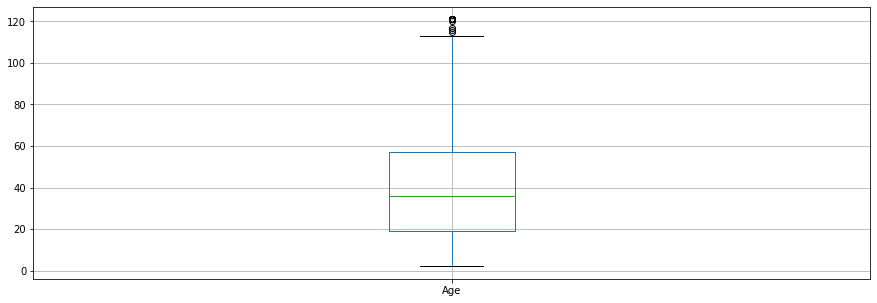

In [10]:
_, a = bridges_reduced.boxplot(column = ['Age'], figsize = (15,5), return_type = 'both')
outliers = [flier.get_ydata() for flier in a["fliers"]]
# boxes = [box.get_ydata() for box in a["boxes"]]
# medians = [median.get_ydata() for median in a["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in a["whiskers"]]
upper_limit = whiskers[1][1]

The upper limit on the box plot beyond which there are outliers is 113. The 'Historic' column from the original dataset is imported into the reduced dataset to check the relationship between the Age variable and the Historic variable.

In [11]:
bridges_reduced = bridges_reduced.assign(Historic = bridges.Historic)
bridges_reduced

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent,Historic
Structure_id,,,,,,,,,
000021521-00101,16,Concrete,Slab,Very Good,Very Good,Good,1,0.0,Not historic
000021521-00181,16,Concrete,Slab,Good,Very Good,Good,1,0.0,Not historic
000021521-TMP20,9,Concrete,Beam,Very Good,Very Good,Very Good,100,0.0,Not historic
000021525-00012,71,Timber,Beam,Good,Poor,Good,80,0.0,Not historic
000021580-00092,17,Concrete,Beam,Very Good,Very Good,Good,150,4.0,Not historic
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,Good,Good,Good,300,40.0,Not historic
DAPFORHOO000013,21,Concrete,Beam,Good,Good,Good,300,40.0,Not historic
DAPFORHOO000015,25,Concrete,Beam,Good,Good,Good,1200,25.0,Not historic


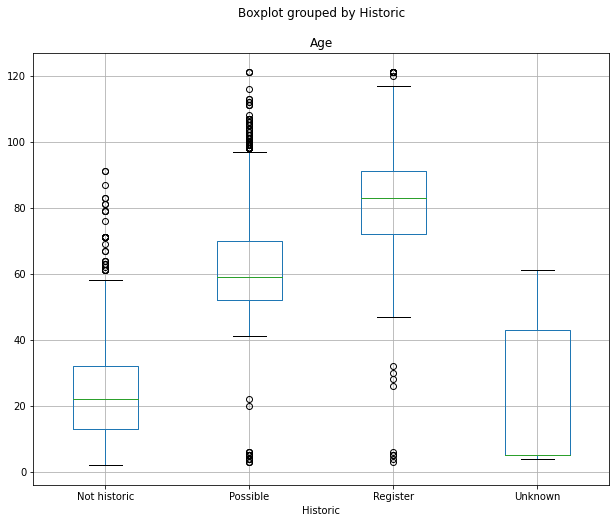

In [12]:
#group Age by historic 
a = bridges_reduced.boxplot(column = 'Age', by = 'Historic', figsize = (10,8), return_type = 'dict')

The above plot indicates that a bridge that is older is more likely to be classed as Historic. The previous threshold value of 113 intersects the upper whisker of the 'Register' category and some outliers in the 'Possible' category. It may be a better choice to use the upper whisker of the 'Possible' category as the threshold, as it will eliminate all the outliers (upper) in that category as well as bridges that are registered as historic (above this threshold), leaving only relatively modern bridges. The below code finds the upper whisker value which turns out to be 97. This will be the threshold above which all data will be eliminated. Note that the data being eliminated by using this method is not necessarily 'bad data' but since it was recommended to eliminate data this way, it has been carried out. A more robust method of detecting and eliminating outliers may be needed as eliminating good data that is relevant to the exercise being carried out (trying to establish if there is a relationship between bridge age and bridge condition) doesn't seem like a good approach.    

In [13]:
#get whisker data for the 'possible' category
whiskers = [whiskers.get_ydata() for whiskers in a[0]["whiskers"]]
upper_limit_possible = whiskers[3] #4th element is the upper whisker for the possible category
upper_limit_possible

array([70., 97.])

Filtering on values where age is greater than 97:

In [14]:
bridges_reduced.loc[(bridges_reduced.Age > 97)]

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent,Historic
Structure_id,,,,,,,,,
010600AA0215001,100,Steel,Beam,Fair,Fair,Satisfactory,40,0.0,Possible
010600AA0215003,100,Steel,Truss,Satisfactory,Very Good,Very Good,70,0.0,Register
011170000908382,100,Concrete,Slab,Satisfactory,Good,Satisfactory,520,9.0,Possible
011170013506033,99,Steel,Beam,Satisfactory,Satisfactory,Good,5060,9.0,Possible
011170013506034,99,Concrete,Slab,Good,Good,Good,5060,9.0,Possible
...,...,...,...,...,...,...,...,...,...
232150001108033,100,Concrete,Beam,Good,Good,Good,8640,18.0,Possible
232150001112058,101,Concrete,Beam,Fair,Satisfactory,Fair,100,8.0,Possible
240720000103041,100,Concrete,Slab,Satisfactory,Satisfactory,Good,33770,6.0,Possible


Dropping these values from the dataset results in a dataset with 266 fewer columns than the original (a 0.78% reduction):

In [15]:
bridges_reduced = bridges_reduced.drop(index = bridges_reduced.loc[(bridges_reduced.Age > 97)].index)
bridges_reduced

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent,Historic
Structure_id,,,,,,,,,
000021521-00101,16,Concrete,Slab,Very Good,Very Good,Good,1,0.0,Not historic
000021521-00181,16,Concrete,Slab,Good,Very Good,Good,1,0.0,Not historic
000021521-TMP20,9,Concrete,Beam,Very Good,Very Good,Very Good,100,0.0,Not historic
000021525-00012,71,Timber,Beam,Good,Poor,Good,80,0.0,Not historic
000021580-00092,17,Concrete,Beam,Very Good,Very Good,Good,150,4.0,Not historic
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,Good,Good,Good,300,40.0,Not historic
DAPFORHOO000013,21,Concrete,Beam,Good,Good,Good,300,40.0,Not historic
DAPFORHOO000015,25,Concrete,Beam,Good,Good,Good,1200,25.0,Not historic


Since no conditions for outliers in other variables were defined, they have been left as they were. However, it is recommended that other variables in the dataset are investigated for outliers if the analysis is carried out again. For example bridges with an average daily of less than 10 that don't have a status of 'local' would indicate incorrect data entry (see example below). However, since the author of this report doesn't have the domain knowledge to confidently define such conditions, it is recommended that the client provides the conditions that will help clean the data better. 

In [16]:
bridges.loc[(bridges.AverageDaily < 10) & (bridges.Status != 'Local')] #bridges that have an average daily of less than 10 but are not classed as local

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
022200ZV4040006,District2,2,Free,Town or City,Urban,Minor,1930,4,4,1,...,22.3,16.5,Very Good,Fair,Satisfactory,0.0,0.0,No waterway,1,91
081280AA0486001,District8,2,Free,County,Rural,Arterial,1990,1,0,0,...,6.7,5.2,Satisfactory,Satisfactory,Satisfactory,20.9,0.0,Dry,200,31
121020011005164,District12,0,Free,State,Urban,Interstate,1995,1,10,1,...,580.6,6.2,Good,Good,Satisfactory,32.7,1.0,No waterway,1,26
121020011005392,District12,0,Free,State,Urban,Interstate,1995,1,5,1,...,176.2,6.2,Good,Good,Good,32.7,1.0,No waterway,1,26
121020011005393,District12,0,Free,State,Urban,Interstate,1995,1,5,1,...,176.2,6.2,Good,Good,Good,32.7,1.0,No waterway,1,26
142270011313476,District14,2,Free,State,Urban,Arterial,2014,1,6,1,...,64.6,9.4,Good,Very Good,Very Good,32.7,0.0,No waterway,54100,7
150950053502112,District15,2,Free,State,Rural,Interstate,1969,2,0,2,...,41.1,9.1,Good,Good,Satisfactory,23.6,39.0,Dry,22560,52
212450AA5013001,District21,5,Free,County,Rural,Minor,2016,2,0,6,...,12.2,10.4,Very Good,Excellent,Very Good,32.7,1.0,Unknown,11,5
240720016701250,District24,2,Free,State,Urban,Arterial,2010,1,8,1,...,611.7,9.1,Good,Very Good,Good,32.7,5.0,No waterway,1,11


The categorical variables 'Design' and 'Material' are investigated next:

In [17]:
# check Material counts and consolidate low numbers into 'other'
bridges_reduced.pivot_table(index= 'Material', aggfunc = 'count', values = 'Age')

,Age
Material,
Concrete,26942
Masonry,10
Other,47
Steel,6563
Timber,465


The above shows the count for each category within the Material variable. Masonry, Other and Timber categories have very few counts compared to the Concrete and Steel. Therefore, it will be easier to carry out the analysis if these small values are consolidated into one variable (in this case 'Other'). Carrying out this consolidation and displaying the new table:

In [18]:
materials_consolidated = {'Masonry':'Other', 'Timber':'Other'}
def replace_material(row):
    if row in materials_consolidated:
        return materials_consolidated[row]
    return row
bridges_reduced.Material= bridges_reduced.Material.map(replace_material) #map the function to all values in the Material column
bridges_reduced.pivot_table(index= 'Material', aggfunc = 'count', values = 'Age')

,Age
Material,
Concrete,26942
Other,522
Steel,6563


Investigating the 'Design' variable next:

In [19]:
#check Design counts and consolidate low numbers into 'other'
bridges_reduced.pivot_table(index= 'Design', aggfunc = 'count', values = 'Age')

,Age
Design,
Arch,134
Beam,28230
Frame,68
Movable,13
Other,1242
Slab,4240
Suspension,5
Truss,95


Carrying out the same exercise as for 'Material' and consolidating Arch, Frame, Movable, Suspension, and Truss with Other:

In [20]:
design_consolidated = {'Arch':'Other', 'Frame':'Other', 'Movable': 'Other', 'Suspension': 'Other', 'Truss': 'Other'}
def replace_design(row):
    if row in design_consolidated:
        return design_consolidated[row]
    return row
bridges_reduced.Design= bridges_reduced.Design.map(replace_design)
bridges_reduced = bridges_reduced.astype({'Material':'category', 'Design':'category'})#set dtype as category 
bridges_reduced.pivot_table(index= 'Design', aggfunc = 'count', values = 'Age')

,Age
Design,
Beam,28230
Other,1557
Slab,4240


After carrying out all the above operations, the dataset looks like this:

In [21]:
bridges_reduced

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent,Historic
Structure_id,,,,,,,,,
000021521-00101,16,Concrete,Slab,Very Good,Very Good,Good,1,0.0,Not historic
000021521-00181,16,Concrete,Slab,Good,Very Good,Good,1,0.0,Not historic
000021521-TMP20,9,Concrete,Beam,Very Good,Very Good,Very Good,100,0.0,Not historic
000021525-00012,71,Other,Beam,Good,Poor,Good,80,0.0,Not historic
000021580-00092,17,Concrete,Beam,Very Good,Very Good,Good,150,4.0,Not historic
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,Good,Good,Good,300,40.0,Not historic
DAPFORHOO000013,21,Concrete,Beam,Good,Good,Good,300,40.0,Not historic
DAPFORHOO000015,25,Concrete,Beam,Good,Good,Good,1200,25.0,Not historic


### Section 1D: Deriving current condition

It has been agreed that the current condition of the bridge needs to be derived from the following variables:

- Deck_rating
- Superstr_rating
- Substr_rating

Investigating these variables below:

In [22]:
bridges_reduced.loc[:,['Deck_rating', 'Superstr_rating', 'Substr_rating']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 34027 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Deck_rating      34027 non-null  category
 1   Superstr_rating  34027 non-null  category
 2   Substr_rating    34027 non-null  category
dtypes: category(3)
memory usage: 366.7+ KB


It has also been agreed that the 'current condition' is the variable that needs to be predicted by the regression model that will be created later in the report. In order for linear regression to be possible, the target variable needs to be of a conitnuous type. Since the above variables from which current condition will be derived consist of categorical data, they will need to be transformed to numerical values. One proposed method of doing so is to assign a numeric value for each category within the above variables:

 - 'Failed': 0 
 - 'Failing': 1
 - 'Critical': 2 
 - 'Serious': 3
 - 'Poor': 4
 - 'Fair': 5 
 - 'Satisfactory': 6
 - 'Good': 7
 - 'Very Good': 8
 - 'Excellent': 9
 
Please note that the above is a rudimentary method of assigning the categories a numeric value and a more robust method will be welcomed from the customer if the above is unsatisfactory. Carrying out the operation to replace the ratings with a numeric value:

In [23]:
bridges_reduced.Deck_rating = bridges_reduced.Deck_rating.cat.codes #change ordinal categorical values to codes
bridges_reduced.Superstr_rating = bridges_reduced.Superstr_rating.cat.codes
bridges_reduced.Substr_rating = bridges_reduced.Substr_rating.cat.codes
bridges_reduced = bridges_reduced.astype({'Deck_rating': 'float', 'Superstr_rating': 'float', 'Substr_rating': 'float'}) #change dtype from int8 to float
bridges_reduced

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent,Historic
Structure_id,,,,,,,,,
000021521-00101,16,Concrete,Slab,8.0,8.0,7.0,1,0.0,Not historic
000021521-00181,16,Concrete,Slab,7.0,8.0,7.0,1,0.0,Not historic
000021521-TMP20,9,Concrete,Beam,8.0,8.0,8.0,100,0.0,Not historic
000021525-00012,71,Other,Beam,7.0,4.0,7.0,80,0.0,Not historic
000021580-00092,17,Concrete,Beam,8.0,8.0,7.0,150,4.0,Not historic
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,7.0,7.0,7.0,300,40.0,Not historic
DAPFORHOO000013,21,Concrete,Beam,7.0,7.0,7.0,300,40.0,Not historic
DAPFORHOO000015,25,Concrete,Beam,7.0,7.0,7.0,1200,25.0,Not historic


The current condition variable is derived by adding the values of Superstr_rating, Substr_rating, Deck_rating:

In [24]:
bridges_reduced = bridges_reduced.assign(Current_condition = bridges_reduced.Deck_rating + bridges_reduced.Superstr_rating + bridges_reduced.Substr_rating)
bridges_reduced

,Age,Material,Design,Superstr_rating,Substr_rating,Deck_rating,AverageDaily,Trucks_percent,Historic,Current_condition
Structure_id,,,,,,,,,,
000021521-00101,16,Concrete,Slab,8.0,8.0,7.0,1,0.0,Not historic,23.0
000021521-00181,16,Concrete,Slab,7.0,8.0,7.0,1,0.0,Not historic,22.0
000021521-TMP20,9,Concrete,Beam,8.0,8.0,8.0,100,0.0,Not historic,24.0
000021525-00012,71,Other,Beam,7.0,4.0,7.0,80,0.0,Not historic,18.0
000021580-00092,17,Concrete,Beam,8.0,8.0,7.0,150,4.0,Not historic,23.0
...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,7.0,7.0,7.0,300,40.0,Not historic,21.0
DAPFORHOO000013,21,Concrete,Beam,7.0,7.0,7.0,300,40.0,Not historic,21.0
DAPFORHOO000015,25,Concrete,Beam,7.0,7.0,7.0,1200,25.0,Not historic,21.0


Retabulating the dataframe so that it displays only the variables that will be used from this point forward:

In [25]:
data_refined = bridges_reduced.drop(['Historic','Superstr_rating','Substr_rating','Deck_rating'], axis = 1).copy()

In [26]:
data_refined

,Age,Material,Design,AverageDaily,Trucks_percent,Current_condition
Structure_id,,,,,,
000021521-00101,16,Concrete,Slab,1,0.0,23.0
000021521-00181,16,Concrete,Slab,1,0.0,22.0
000021521-TMP20,9,Concrete,Beam,100,0.0,24.0
000021525-00012,71,Other,Beam,80,0.0,18.0
000021580-00092,17,Concrete,Beam,150,4.0,23.0
...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,300,40.0,21.0
DAPFORHOO000013,21,Concrete,Beam,300,40.0,21.0
DAPFORHOO000015,25,Concrete,Beam,1200,25.0,21.0


## Section 2 -  Exploratory analysis

This section will investigate the relationship between all the predictors, and the relationship between the predictors and the target variable (Current_condition).

Since the variables are a mix of continous and categorical, the following approach will be adopted:

 - Relationship between continuous variables will be determined using a combination of scatter matrix and correlation matrix heat map
 - Relationship between categorical variables will be determined using contingency tables(bar charts) and conditional probability heat maps
 - Relationship between categorical and continuous variables will be determined using histograms/ kernel density estimates by categorical groups

As a reminder, the variables are as follows:

- Continuous variables = Age, AverageDaily, Trucks_percent, Current_condition
- Categorical = Material, Design

### Section 2A: Relationship between continuous variables

Plotting the heat map and scatter matrix for the continuous variables first:

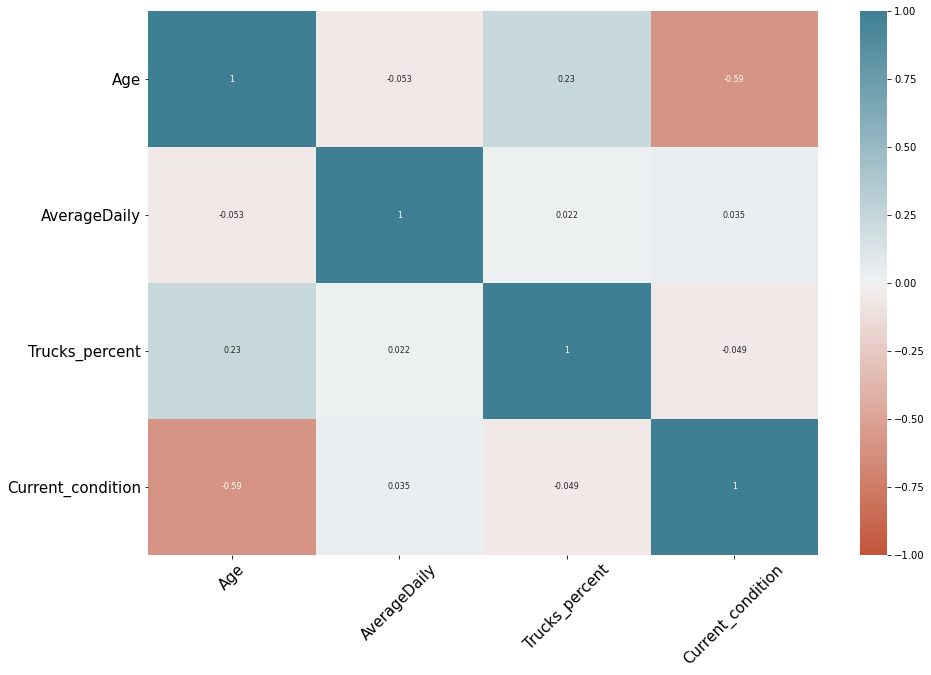

In [27]:
# correlation heatmap using seaborn library
fig,ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(data_refined.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 8})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

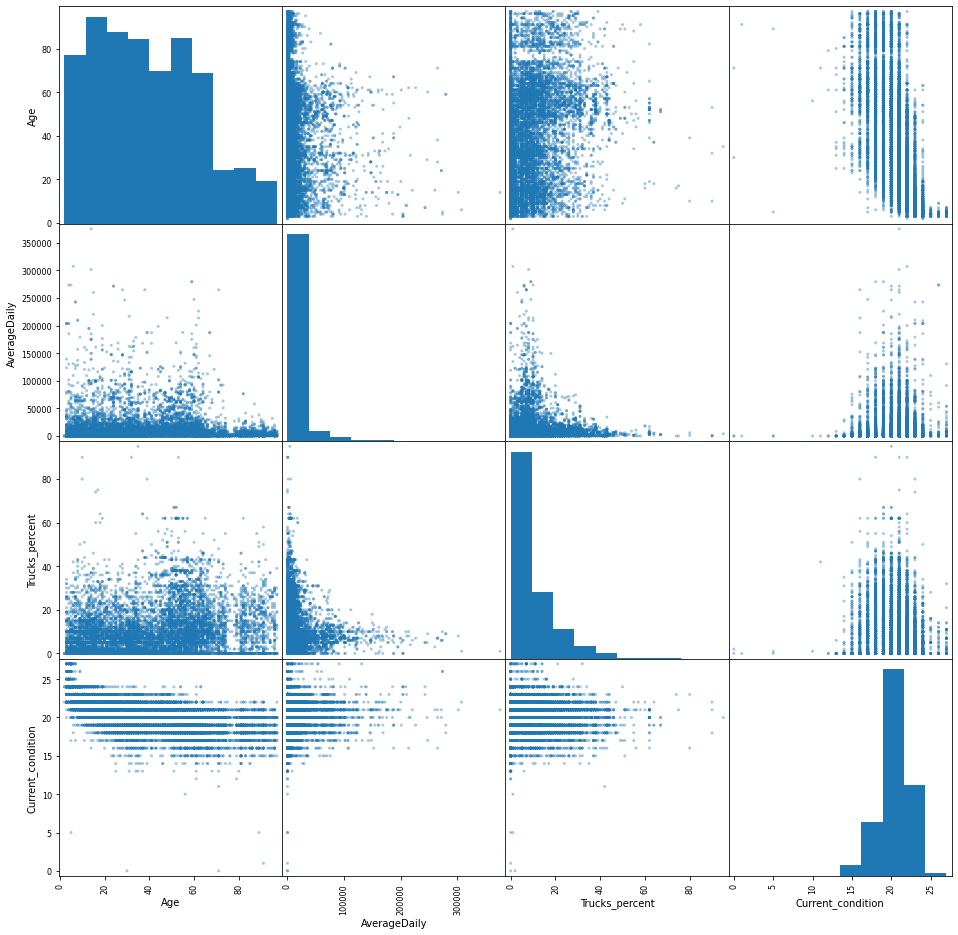

In [28]:
#scatter matrix on 40% of the data
a_ = pd.plotting.scatter_matrix(data_refined.sample(frac=0.40), alpha = 0.4, figsize=(16,16), diagonal = 'hist')

The above plots seem to indicate that in general, the continuous predictors are not co-linear or dependent on each other. However, there seems to be a clear negative correlation between Age and Current_condition(target variable). This relationship is discernable on the scatter plot, but the heat map shows a more clear value of -0.59 as the correlation coefficient between the two. Therefore there is some indication that as the age of the bridge increases, the condition of the bridge gets worse. Since the other continuous predictors don't seem to have any outright relationship with the target variable, it is assumed at this point that the Age variable will have a bigger impact on the current condition compared to AverageDaily or Trucks_percent variables. However, before making any definitive conclusions, the relationships between the categorical variables, and categorical and continuous variables still need to be looked at in detail. 

### Section 2B: Relationship between categorical variables

Creating contingency tables to look at the relationship between Design and Material categories:   

In [29]:
# cross tab for categorical variables
#joint probability - normalise all
des_and_mat = pd.crosstab(data_refined.Design, [data_refined.Material], normalize='all', margins = False)
mat_and_des = pd.crosstab(data_refined.Material, [data_refined.Design], normalize='all', margins = False)
# Conditional probabilities - normalise index
mat_given_des = pd.crosstab(data_refined.Design, [data_refined.Material], normalize='index')
des_given_mat = pd.crosstab(data_refined.Material, [data_refined.Design], normalize = 'index')

Joint probability distribution for Design and Material:

In [30]:
des_and_mat.round(4)*100

Material,Concrete,Other,Steel
Design,,,
Beam,63.61,1.36,17.99
Other,3.11,0.17,1.30
Slab,12.46,0.00,0.00


The above table shows the joint probability distribution for the two categorical variables. It shows that out of all the bridges, around 83% are likely to be of beam design and around 80% are likely to be concrete. 63.6% of all bridges are of beam type and made of concrete.

The below shows the conditional probability of design given a material. It's represented as a heatmap:

Text(0.5, 1.0, 'Design given Material')

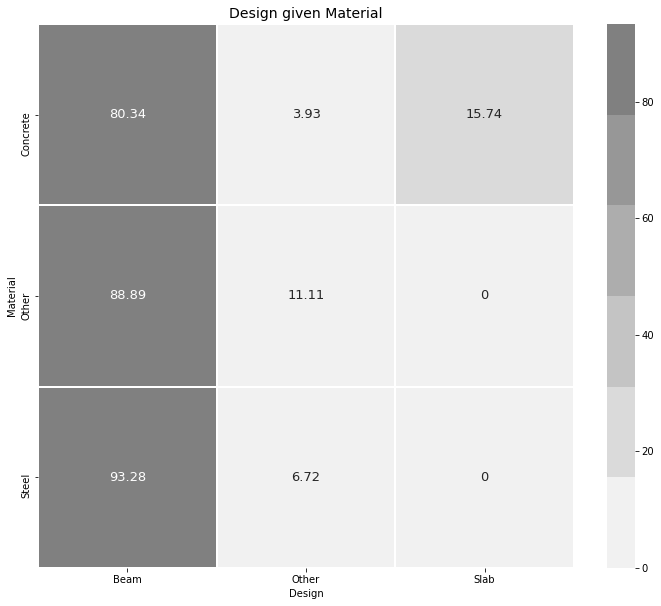

In [31]:
fig,ax = plt.subplots(1,1, figsize=(12,10))
sns.heatmap(des_given_mat.round(4)*100, cmap=sns.light_palette('grey'), linewidths = 2,
           annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('Design given Material', fontsize=14)

The above shows that for any given material, it is highly likely that the design of the bridge is of 'Beam' type. For example, given a bridge made of Steel, there is a 93.3% chance it is of Beam type. Repeating the same but the other way around (probability of material given design):

Text(0.5, 1.0, 'Material given Design')

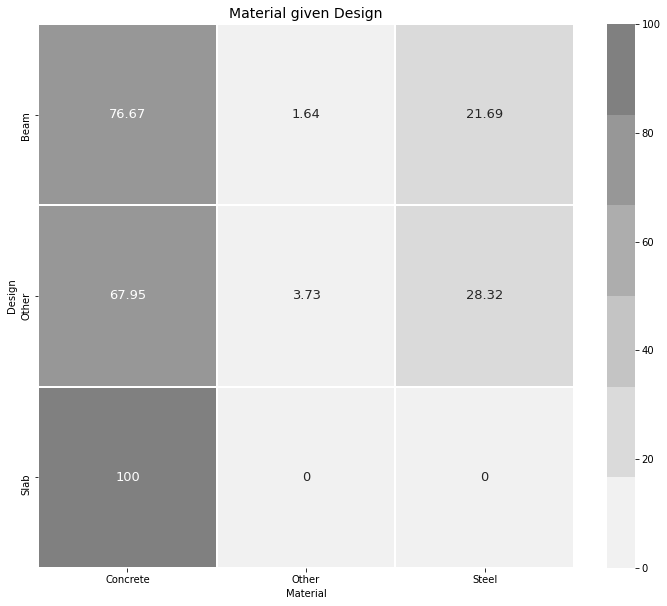

In [32]:
fig,ax = plt.subplots(1,1, figsize=(12,10))
sns.heatmap(mat_given_des.round(4)*100, cmap=sns.light_palette('grey'), linewidths = 2,
           annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('Material given Design', fontsize=14)

The above shows that given any bridge with any design type, it is highly likely to be made of concrete. This is especially true for the 'slab' type where the probability that the material is concrete is 100%. Out of all 'Beam' type bridges, around 21.7% are made of steel, and 76.7% are made of concrete. Given any design type other than beam or slab, 68% are likely to be concrete whereas 2.3% are likely to be steel.

Summarising the above analysis as bar charts:

Text(0.5, 1.0, 'Probability of Design, given Material')

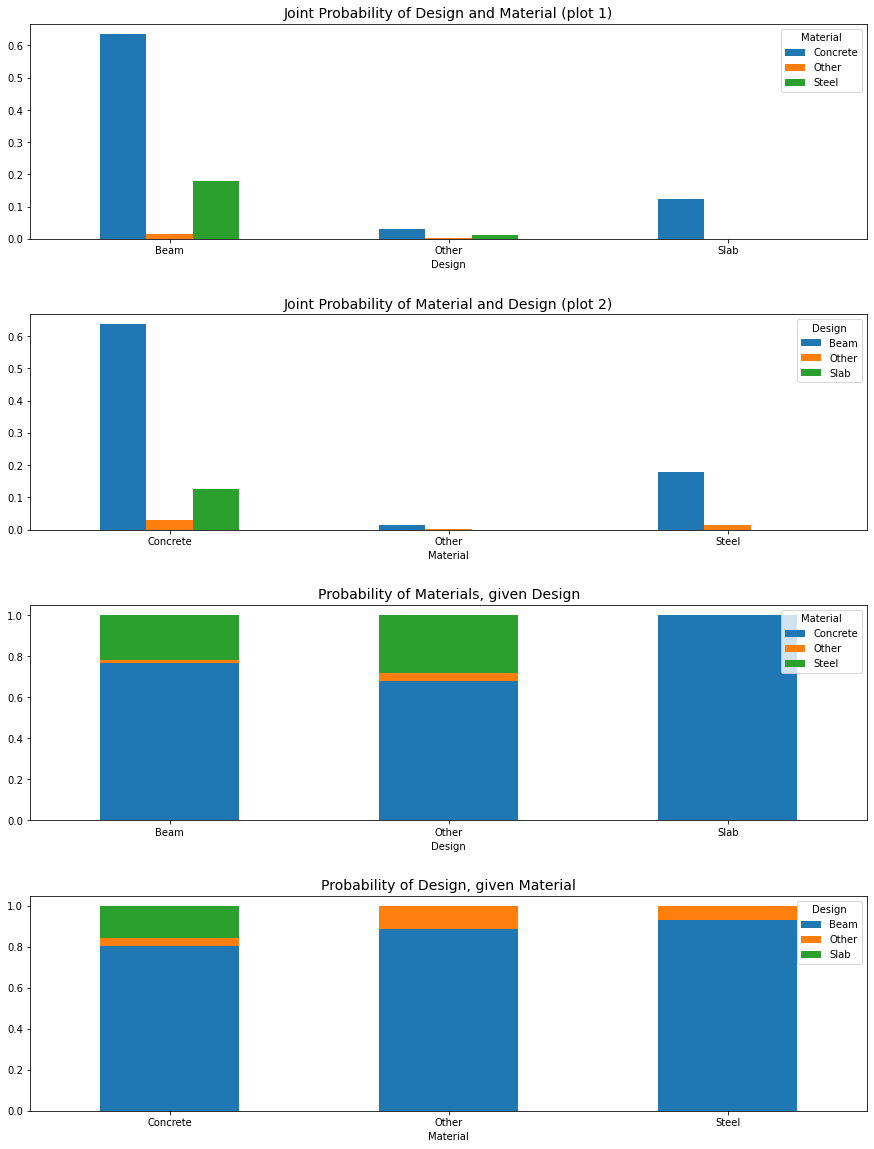

In [33]:
# Generate suitable axes
fig,(a1, a2, a3, a4) = plt.subplots(4,1,figsize=(15,20), sharey=False, sharex=False)
fig.subplots_adjust(hspace=0.35)

des_and_mat.plot(kind='bar', subplots=False, ax=a1, rot=0)
a1.set_title('Joint Probability of Design and Material (plot 1)', fontsize=14)

mat_and_des.plot(kind='bar', subplots=False, ax=a2, rot=0)
a2.set_title('Joint Probability of Material and Design (plot 2)', fontsize=14)

mat_given_des.plot(kind='bar', subplots=False, ax=a3, rot=0, stacked=True)
a3.set_title('Probability of Materials, given Design', fontsize=14)

des_given_mat.plot(kind='bar', subplots=False, ax=a4, rot=0, stacked = True)
a4.set_title('Probability of Design, given Material', fontsize=14)

The above shows that there is a heavy relationship between material and design. The relationship between these categorical predictors and the continuous variables (predictors and target) will be investigated next.

### Section 2C: Relationship between continuous and categorical variables

The relationship between each group in Material and Design and all continuous variables is displayed below using histograms as they give the clearest picture of the distribution and hence the relationship. Looking at Material first:

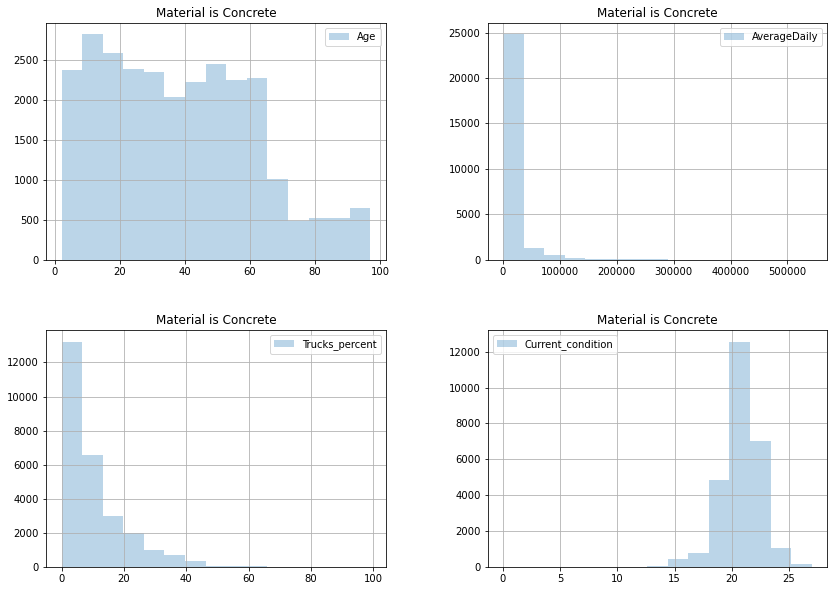

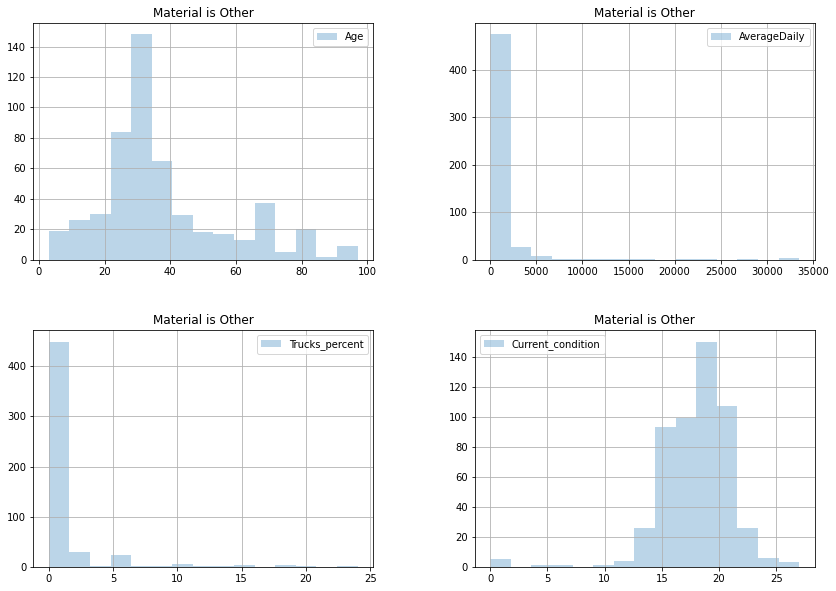

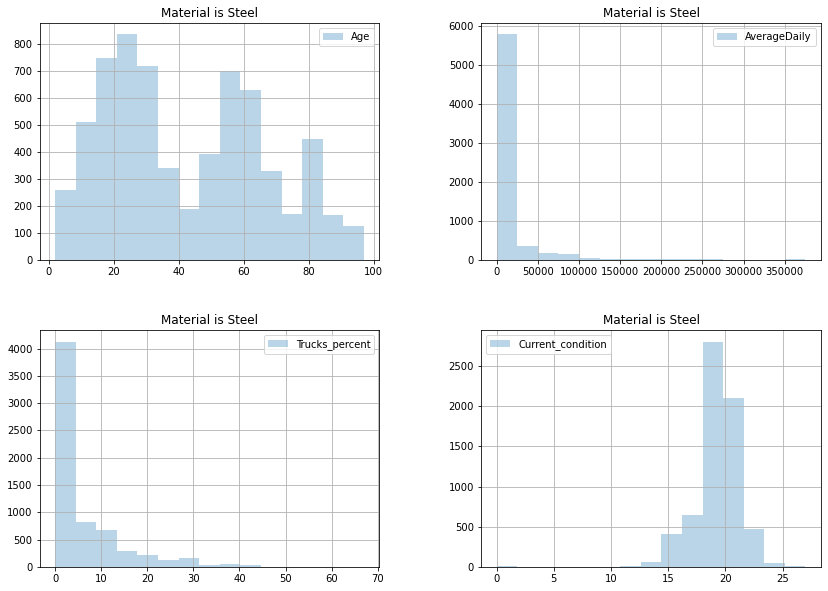

In [34]:
gbyMaterial = data_refined.groupby(by = 'Material', dropna = False) # group by material

axs = gbyMaterial.hist(column=['Age', 'AverageDaily', 'Trucks_percent', 'Current_condition'], alpha=0.3, bins=15, density=False, figsize=(14,10), legend=True, log = False)

# This sets the titles
names = ['Concrete', 'Other', 'Steel']
_t = [axs[name][row][col].set_title('Material is ' + name) for name in names for row,col in [[0,0],[0,1],[1,0],[1,1]]]

The following can be inferred from the above:

- Concrete has been the most popular material for bridges (almost a uniform distibution over the last 60 years) over time with steel behind it. Steel seems to have gone through different phases of being popular and unpopular over time (tri-modal distribution). 30 years ago there was a surge (in relative proportion) of bridges that were constructed out of material other than steel or concrete but the trend did not carry on. There doesn't seem to be a clear linear relatioship between age and material type. 
- None of the material types seem to have any direct relationship to the AverageDaily and Trucks_percent variable. All of them are heavily positively skewed and the only conclusion that can be drawn from the graphs is that a larger proportion of trucks and daily traffic are found on concrete bridges as opposed to the others. This is to be expected as the majority of the bridges in the data are made of concrete (around 80% as shown previously).
- Comparing the material type to the target variable (Current_condition), it can be seen that concrete has a higher mean and median than both 'other' and steel, and the variance around the mean is lower as well. Other has the highest variance and steel is in the middle. Thus, material type should play a somewhat significant role as a predictor in the linear regression model that will be derived later. 

Carrying out the same exercise for Design:

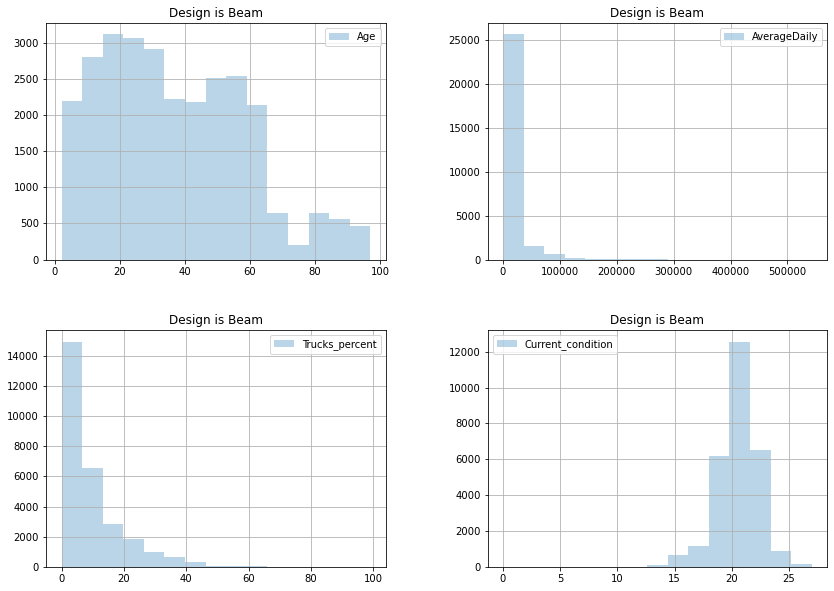

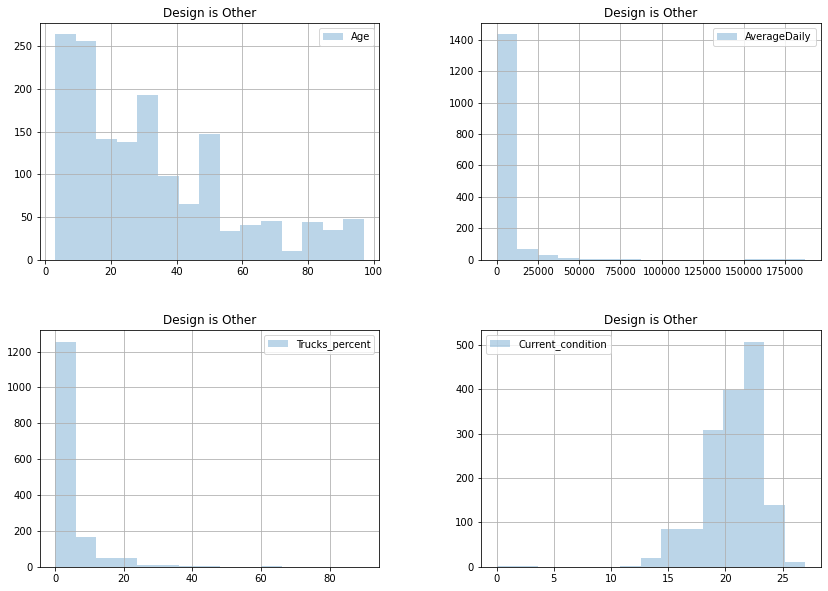

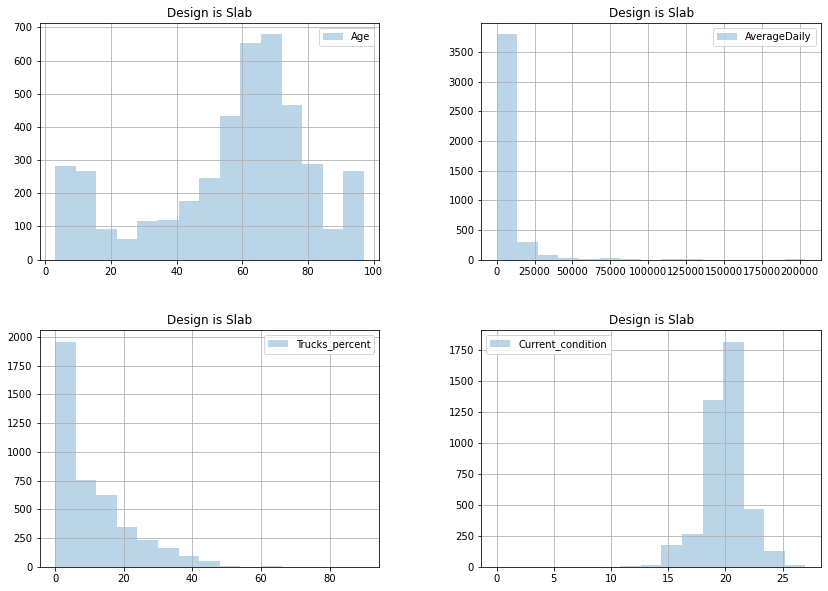

In [35]:
#Group by design
gbyDesign = data_refined.groupby(by = 'Design', dropna = False)

axs = gbyDesign.hist(column=['Age', 'AverageDaily', 'Trucks_percent', 'Current_condition'], alpha=0.3, bins=15, density=False, figsize=(14,10), legend=True)

# This sets the titles
names = ['Beam', 'Other', 'Slab']
_t = [axs[name][row][col].set_title('Design is ' + name) for name in names for row,col in [[0,0],[0,1],[1,0],[1,1]]]

The following can be inferred from the above:

- Beam type has been the most popular design in the last 60 years or so, whereas slab used to be more popular before then (only slightly). Beam was still used for bridges older than 60 and it was more popular than slab, but slab overtook beam for a couple of decades before gradually falling down to low numbers. It does seem to have made a slight resurgence (relative to its previous years but still no competition to beam) in the last 20 years or so. 'Other' design types have gained popularity over the years as well and they are at the highest they have ever been (but still the smallest proportion of all design types). There is a slight relationship between age and design type that may affect the regression coefficients very slightly when one or the other is removed.  

- Similar to the material investigation, design type does not seem to have any direct relationship with AverageDaily and Trucks_percent variables.

- The 'Other' design type seems to have the highest mean and median when compared to slab or beam but it also seems to have the widest spread. This is to be expected due to the fewer datapoints available for this category. It's difficult to infer the statistics for slab and beam by eye so the below code can be used to get the data. The mean and median are around 19.7 and 20 respectively for slab with a standard deviation of 2.02. For beam, the mean and median are around 20.4 and 21 respectively, and the standard deviation is 1.93. Thus there is a slight relationship between design type and current condition that should be reflected in the regression model. The influence is expected to be low but present.

In [36]:
#use below to get mean, median, std for current condition for beam and slab
# gbyDesign.get_group('Beam').describe()
# gbyDesign.get_group('Slab').describe()

### Preliminary conclusions: 

Following the above analysis into the relationships between all the variables, the following conclusions can be reached with regards to the original questions that need to be answered:

- The current set of proposed variables would predict an imperfect fitting model as apart from Age, there doesn't seem to be any strong correlation between the predictor variables and the target variable. Some of the predictors are heavily skewed and the model may not perform as well due to this. The expectation is that this will result in a model with large errors/ variances. 
- Some of the proposed variables should be better at predicting the condition of the bridge than others. Age seems to be the best predictor and should have the most influence on the model. Material type is expected to be the next best predictor and design may play a very minute role as well. AverageDaily and Trucks_Percent are expected to have very little (close to zero) influence on the predicted value.

## Section 3 - Regression modelling

### Section 3A: Reference Encoding categorical variables

Since regression model can't be built with categorical variables, the Material and Design variables in the dataset need to be converted to numeric values. This will be done using the method of 'reference encoding'. Separate datasets for design and material variables are created below with dummy values for the categories within. The reference category (concrete for material and beam for design in this case) are dropped from the dataset. The design and material datasets are shown below after the encoding has been carried out.

In [37]:
design_d = pd.get_dummies(data_refined.Design, drop_first = True)
design_d

,Other,Slab
Structure_id,,
000021521-00101,0,1
000021521-00181,0,1
000021521-TMP20,0,0
000021525-00012,0,0
000021580-00092,0,0
...,...,...
DAPFORHOO000012,0,0
DAPFORHOO000013,0,0
DAPFORHOO000015,0,0


In [38]:
material_d = pd.get_dummies(data_refined.Material, drop_first = True)
material_d

,Other,Steel
Structure_id,,
000021521-00101,0,0
000021521-00181,0,0
000021521-TMP20,0,0
000021525-00012,1,0
000021580-00092,0,0
...,...,...
DAPFORHOO000012,0,0
DAPFORHOO000013,0,0
DAPFORHOO000015,0,0


### Section 3B: Linear regression and analysis

Building the X matrix and y vector, and carrying out the linear regression:

In [39]:
#Build X matrix
X = np.column_stack((data_refined.Age, data_refined.AverageDaily, data_refined.Trucks_percent, material_d.Other, material_d.Steel, design_d.Other, design_d.Slab))
# Build y matrix
y = data_refined.Current_condition
#fit the model and print results
regression = LinearRegression().fit(X,y)
print('The R2 coefficient of determination is %4.3f' % regression.score(X, y))
print('The intercept is %4.1f' % regression.intercept_)
print('The regression coefficients are:', regression.coef_)

The R2 coefficient of determination is 0.450
The intercept is 22.5
The regression coefficients are: [-4.92694670e-02 -6.81795780e-07  5.57918800e-03 -2.82019314e+00
 -1.37273189e+00  9.97442036e-02 -6.93845079e-02]


The coefficient of determination is 0.45, i.e., only 45% of the total variation of the response variable can be explained by the model. The regression model doesn't fit the data very well and most of the variance (55%) is unaccounted for. 

The intercept is 22.5. This means that for a bridge with age 0, no daily traffic, no truck traffic, made of concrete, and has a beam design, the model will predict a rating of 22.5. This roughly equates to at least 'Good' on all three original categories of Superstr_rating, Substr_rating, and Deck_rating. This prediction can be classed as decent but not accurate as one would expect a score of 27 for a brand new bridge with no traffic on it and made with the most popular materials and design type.

The regression coefficents calculated above are absolute in nature and haven't been scaled/ normalised. They don't indicate any effect on each other and only indicate the magnitude of change on the target variable when all other predictors are constant. Examining them one by one:

 - The coefficient of the age predictor is around -0.05 change of current condition rating per year. This implies that for all other predictors being constant, if the bridge is 10 years old, the value of the current condition rating will decrease by 0.5, i.e, the bridge gets worse as it ages. 
 - The coefficient of AverageDaily is $-6.82*10^{-7}$ change of current condition rating per daily traffic. This implies that for all other predictors being constant, if the bridge has an average daily traffic of 100,000, the value of the current condition rating will decrease by 0.0682. i.e, the bridge gets worse as it sees more traffic. However, note that the change in current condition is minute for a value of 100,000. To reduce the rating by 1 point, the average daily traffic would need to be around $1.5*10^6$. Thus, the average daily traffic doesn't have a lot of effect on the target variable.
 - For Truck_percent, the coefficient is 0.0056 change in current condition rating per percentage of truck traffic. Note that this seems a bit suspect as this implies that a 100% traffic will result in the current rating increasing by 0.56. 
 - For the last 4 variables related to material and design, it is important to remember that all the material variables (steel and other) are related to each other and all the design variables (other and slab) are related to each other. This is beacuse they are binary values based on a reference category (concrete for material and beam for design). Also note, that we established before that there is a relationship between design and material categories as a whole. For example, if the value of slab is 1, it is certain that the values of 'other' design, 'other' material, and steel will be 0 (since all slab design types are made of concrete). In this case, the current rating of the bridge will reduce by 0.07 (coefficient of slab) given all others are constant. 
 
To understand the influence of the predictors compared to each other, the regression is carried out again but this time, the X values are standardised using the z-score method: 

In [40]:
Z = StandardScaler().fit_transform(X)

reg1 = LinearRegression().fit(Z, y)
print('The R2 coefficient of determination is %4.3f' % reg1.score(Z, y))
print('The intercept is %4.1f' % reg1.intercept_)
print('The regression coefficients are:', reg1.coef_)

The R2 coefficient of determination is 0.450
The intercept is 20.3
The regression coefficients are: [-1.14718613 -0.01657314  0.0577875  -0.34661332 -0.54162058  0.02084248
 -0.02291581]


As it can be seen from the above, for the same change in any variable, the age variable seems to be the most influential variable with material (steel) and material (other) being the runner ups. This confirms our intial conclusions from the exploratory analysis carried out in an earlier section. 

Plotting the residual errors distribution and testing the normality on a qqplot:

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


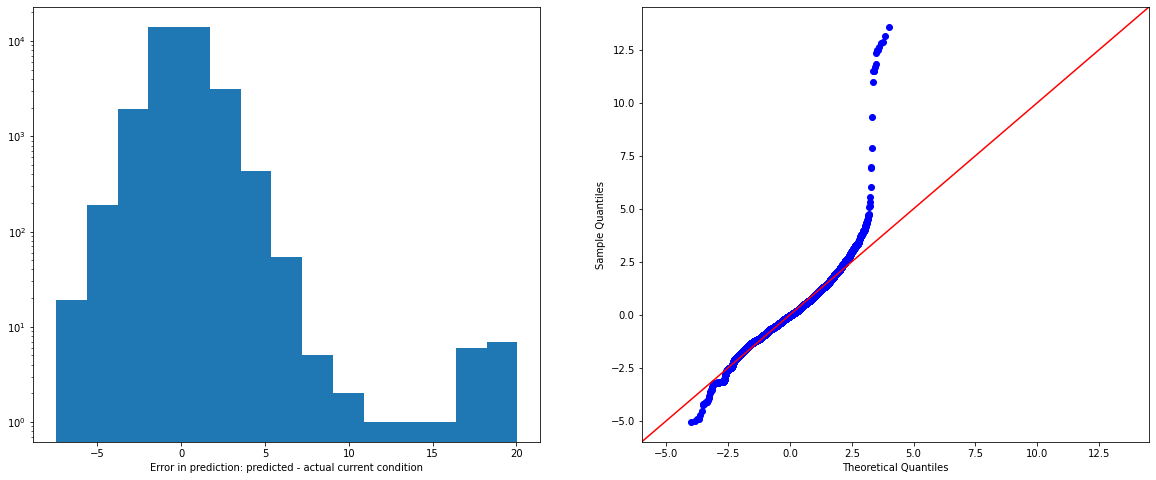

In [41]:
y_hat = regression.predict(X) #predicted values

fig, (a1,a2) = plt.subplots(1, 2, figsize = (20,8))
residuals = y_hat - y
a1.hist(residuals, bins=15, density=False, log = True)
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')

import scipy.stats as stats
import statsmodels.api as sm  # needed for the qqplot

f = sm.qqplot(residuals, fit=True, line='45', ax =a2)

In [42]:
print('The mean and standard deviation of the residual errors are: {0:.3f} and {1:.3f}'.format(residuals.mean(), residuals.std()))

The mean and standard deviation of the residual errors are: 0.000 and 1.476


While the mean of the residual errors is 0 with a standard deviation of 1.5, and the residual error distribution looks normal, there are a few outliers that cause the error distribution to be not normally distributed and have a positive skew with a long right tail. The QQ-plot confirms this. Plotting the residuals against the predicted value, one would expect a random symmetric distribution around the 0 value (no error). However, it can be seen that the predicted values seem to have an upward trending pattern. The outliers are easily visible and indicate that the model has room for improvement. The striped upward pattern of the data is due to the fact that the target variable (the actual current condition) is actually discrete and not continuous with the method chosen here to convert ratings to codes. Thus, for the same actual value, there are multiple predicted values which causes a linear relationship between the error and the predicted value for a given actual value. This might be resolved by providing a slight jitter in the input data or by having a better method of converting categorical ratings to continuous ones.  

Text(0, 0.5, 'Actual Value')

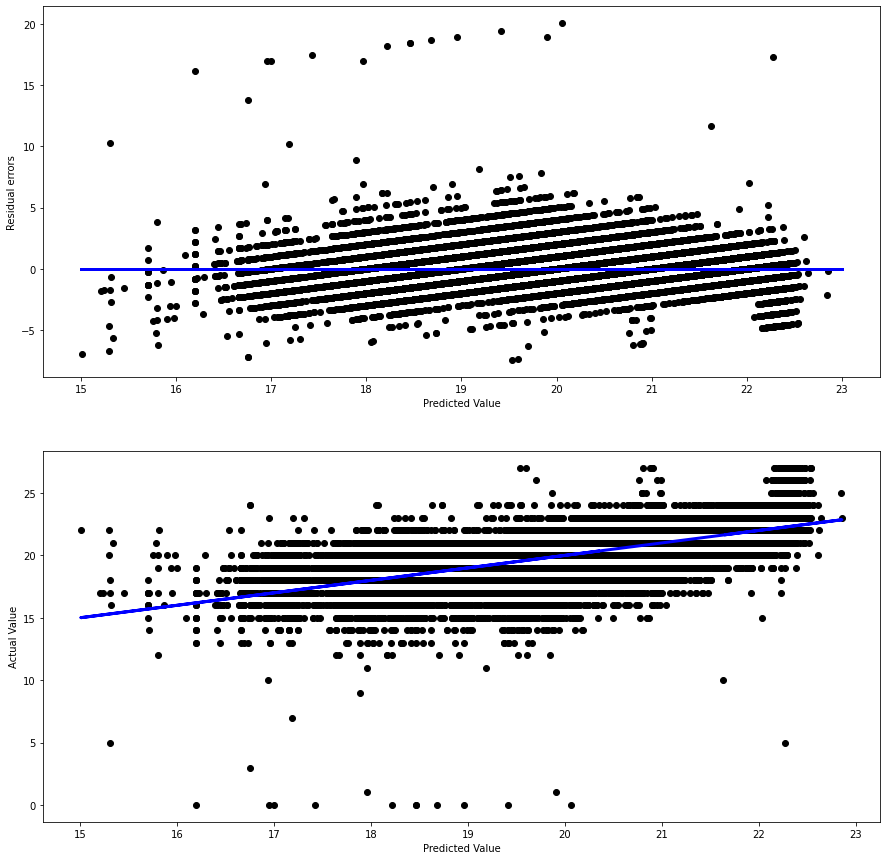

In [43]:
fig, (a1,a2) = plt.subplots(2,1,figsize=(15,15))
a1.scatter(y_hat, residuals,  color='black')
a1.plot([15,23],[0,0], color='blue', linewidth=3)
a1.set_xlabel('Predicted Value')
a1.set_ylabel('Residual errors')

a2.scatter(y_hat, y,  color='black')
a2.plot(y_hat,y_hat, color='blue', linewidth=3)
a2.set_xlabel('Predicted Value')
a2.set_ylabel('Actual Value')

### Section 3C: Removing outliers and re-running the model

Investigating the extreme outliers in the residual data (where error is greater than 10):

In [44]:
outliers = residuals.loc[residuals>10].index #store data for bridges where residuals are greater than 10
data_refined = data_refined.assign(predicted_condition = y_hat) #display predicted values in the data
data_refined.loc[outliers] #display outliers in the data

,Age,Material,Design,AverageDaily,Trucks_percent,Current_condition,predicted_condition
Structure_id,,,,,,,
010750AA0230001,50,Steel,Beam,10,0.0,0.0,18.676822
010920AA0504001,46,Other,Beam,60,0.0,0.0,17.426404
021840C01410001,89,Other,Beam,50,0.0,5.0,15.307824
052190AA0193007,86,Steel,Other,50,0.0,0.0,17.002838
061950AA0184001,85,Steel,Beam,1,0.0,0.0,16.952396
081280AA0153001,18,Concrete,Beam,50,0.0,10.0,21.626149
090740AA0168001,71,Other,Beam,50,0.0,0.0,16.194674
090740AA0254001,91,Steel,Other,55,0.0,3.0,16.756487
090740AA0299001,25,Other,Beam,100,0.0,0.0,18.461036


Since the regression model is influenced primarily by Age, and Material type, it is not surprising that the above bridges were predicted to have a higher rating than the actual rating. There are some bridges in the above data that are less than 50 years old, made of concrete and beam, and still have an actual current condition rating of less than 10. It will be worth investigating whether these bridges reflect reality or are classed incorrectly. It could be that some of these bridges genuinely failed after coming into service less than 50 years ago. Taking these values prima facie and assuming that these bridges are genuine outliers, the regression can be performed again after excluding the above to see the change.

In [45]:
data_refined_outl_drop = data_refined.drop(index = outliers).copy()
data_refined_outl_drop #data with the 18 outliers dropped 

,Age,Material,Design,AverageDaily,Trucks_percent,Current_condition,predicted_condition
Structure_id,,,,,,,
000021521-00101,16,Concrete,Slab,1,0.0,23.0,21.655337
000021521-00181,16,Concrete,Slab,1,0.0,22.0,21.655337
000021521-TMP20,9,Concrete,Beam,100,0.0,24.0,22.069540
000021525-00012,71,Other,Beam,80,0.0,18.0,16.194654
000021580-00092,17,Concrete,Beam,150,4.0,23.0,21.697667
...,...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,300,40.0,21.0,21.405721
DAPFORHOO000013,21,Concrete,Beam,300,40.0,21.0,21.701338
DAPFORHOO000015,25,Concrete,Beam,1200,25.0,21.0,21.419959


In [46]:
#creating new reference encoded datasets for material and design with the outliers removed
material_d_drop = pd.get_dummies(data_refined_outl_drop.Material, drop_first = True)
design_d_drop = pd.get_dummies(data_refined_outl_drop.Design, drop_first = True)

The R2 coefficient of determination is 0.463
The intercept is 22.5
The regression coefficients are: [-4.90317771e-02 -7.77058136e-07  5.05767527e-03 -2.61667919e+00
 -1.36280460e+00  1.03878764e-01 -6.83293501e-02]


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)



The mean and standard deviation of the residual errors are: -0.000 and 1.424


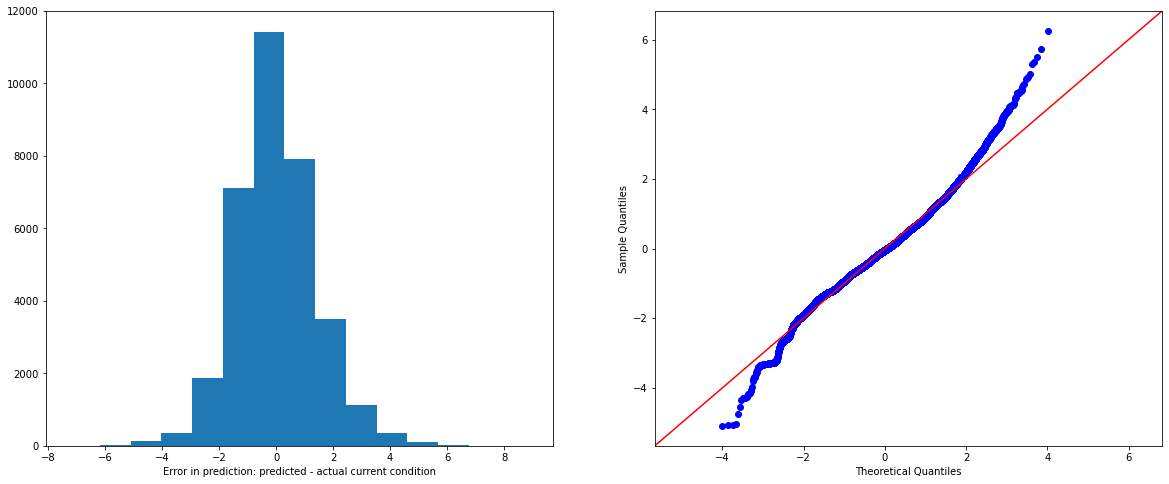

In [47]:
#regression model for data with outliers removed
#Build X matrix
X2 = np.column_stack((data_refined_outl_drop.Age, data_refined_outl_drop.AverageDaily, data_refined_outl_drop.Trucks_percent, material_d_drop.Other, material_d_drop.Steel, design_d_drop.Other, design_d_drop.Slab))
# Build y matrix
y2 = data_refined_outl_drop.Current_condition
#fit the model and print results
reg2 = LinearRegression().fit(X2,y2)
print('The R2 coefficient of determination is %4.3f' % reg2.score(X2, y2))
print('The intercept is %4.1f' % reg2.intercept_)
print('The regression coefficients are:', reg2.coef_)

#residual distribution:
y_hat2 = reg2.predict(X2) #predicted values

fig, (a1,a2) = plt.subplots(1, 2, figsize = (20,8))
residuals2 = y_hat2 - y2
a1.hist(residuals2, bins=15, density=False, log = False)
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')

#residual normality check:
import scipy.stats as stats
import statsmodels.api as sm  # needed for the qqplot

f = sm.qqplot(residuals2, fit=True, line='45', ax =a2)
#residual descriptive stats:
print('\nThe mean and standard deviation of the residual errors are: {0:.3f} and {1:.3f}'.format(residuals2.mean(), residuals2.std()))

As shown above, the model performed slightly better this time with a R2 coefficient of 0.463 as opposed to 0.45. The distribution of the errors is more normal but the QQ-plot suggests there are still some outliers that are extreme and hence the model still has room for improvement. Plotting the errors against the predicted value and actual against predicted value, the errors are more evenly distributed around the 0 error line but the non continuous nature of the target variable (actual condition), and the reliance on only age and material predominantly, causes the distribution to be heavily patterned. 

Text(0, 0.5, 'Actual Value')

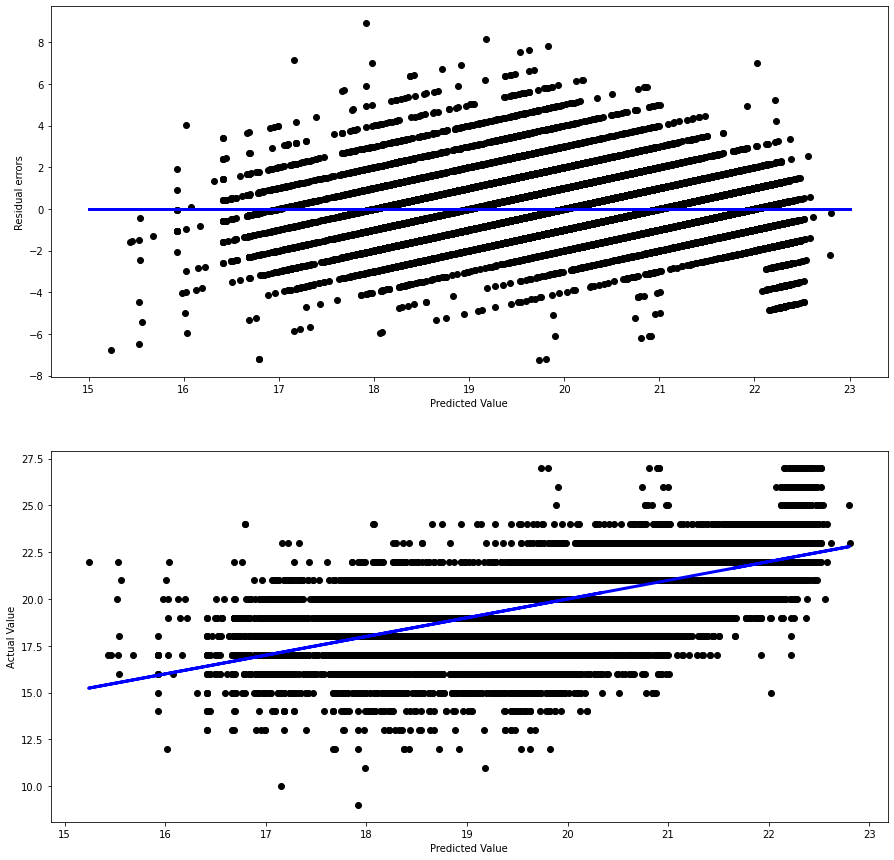

In [48]:
fig, (a1,a2) = plt.subplots(2,1,figsize=(15,15))
a1.scatter(y_hat2, residuals2,  color='black')
a1.plot([15,23],[0,0], color='blue', linewidth=3)
a1.set_xlabel('Predicted Value')
a1.set_ylabel('Residual errors')

a2.scatter(y_hat2, y2,  color='black')
a2.plot(y_hat2,y_hat2, color='blue', linewidth=3)
a2.set_xlabel('Predicted Value')
a2.set_ylabel('Actual Value')

## Section 4 - Conclusions

A regression model was built to predict the current condition of texas bridges based on five predictor variables: Age, AverageDaily, Trucks_percent, Material, and Design. It was found that the model has a coefficient of determination of 0.45, i.e, the model is only capable of explaining 45% of the total variance. Age was the major influencer on the dependent variable, with Material types being the next best in terms of correlation with the target variable. AverageDaily, Trucks_percent, and Design were not too influential. Examining the residual errors' distribution revealed a skewed distribution with outliers, and the errors having a pattern when plotted against predicted values. The obvious extreme outliers were removed and the regression was performed again, resulting in a slightly better model (R2 = 0.463) with more normally distributed resiudal errors but not perfect, suggesting that the model can be improved upon. 

It is recommended that the analysis be carried out again with some of the same predictors (Age and material types) after a thorough data cleaning procedure with well defined conditions for outlier removal has been established and executed. It is also recommended that if skewed continuous variables are being used for regression, a transformation methodology be applied to them for a better model. A better, more accurate method of transforming Superstr_ratin, Deck_rating, and Substr_rating categories to continuous variables is recommended as well (provided by the client) as that will ensure the target variable is truly continuous in nature, and the ratings are more representative of the actual condition (i.e., the distances between each subsequent rating is not constant as it was in this case). More variables should be looked at to see if there is one with more correlation with the target variable than Age. The data suggests that there must be one or more variables out there that can explain the majority of the variance between the actual and predicted condition. This conclusion was reached by thinking about the fact that for a given actual condition rating, there are multiple bridges with that rating that have a wide range of predicted values. Thus, there must be a variable or multiple variables, in addition to Material and Age, that would allow that variance to be reduced. 